In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import random
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

2.0.0-rc1


In [2]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [3]:
input_directory = r"data/chest_xray/"
training_dir = pathlib.Path(input_directory + r"train")
validation_dir = pathlib.Path(input_directory + r"val")
testing_dir = pathlib.Path(input_directory + r"test")

In [4]:
for item in training_dir.iterdir():
  print(item)

data\chest_xray\train\NORMAL
data\chest_xray\train\PNEUMONIA


In [5]:
train_images = list(training_dir.glob('*/*.jpeg'))
train_images = [str(path) for path in train_images]
random.shuffle(train_images)
test_images = list(testing_dir.glob('*/*.jpeg'))
test_images = [str(path) for path in test_images]
random.shuffle(test_images)

image_count = len(train_images)
image_count

5216

In [6]:
label_names = sorted(item.name for item in training_dir.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
train_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in train_images]
test_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in test_images]
print("First 10 labels indices: ", train_image_labels[:10])

First 10 labels indices:  [1, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [8]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [9]:
train_path_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls = AUTOTUNE)
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_image_labels, tf.int64))
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
train_image_label_ds

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [10]:
test_path_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls = AUTOTUNE)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_image_labels, tf.int64))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
test_image_label_ds

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [11]:
BATCH_SIZE = 32
EPOCHS = 10

#train_ds = train_image_label_ds.cache()
train_ds = train_image_label_ds.shuffle(buffer_size=image_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
train_ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [12]:
#train_ds = test_image_label_ds.cache()
test_ds = test_image_label_ds.shuffle(buffer_size=image_count)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
test_ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [13]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

In [14]:
model = tf.keras.Sequential([
    inception_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 65538     
Total params: 21,868,322
Trainable params: 21,833,890
Non-trainable params: 34,432
_________________________________________________________________


In [15]:
steps_per_epoch=tf.math.ceil(len(train_images)/BATCH_SIZE).numpy()
steps_per_epoch

163.0

In [16]:
validation_steps=tf.math.ceil(len(test_images)/BATCH_SIZE).numpy()
validation_steps

20.0

In [17]:
r = model.fit(train_ds, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=test_ds, validation_steps=validation_steps)

Train for 163.0 steps, validate for 20.0 steps
Epoch 1/10
163/163 [==============================] - 87s 537ms/step - loss: 0.2047 - accuracy: 0.9402 - val_loss: 342.6759 - val_accuracy: 0.6453
Epoch 2/10
163/163 [==============================] - 58s 354ms/step - loss: 0.0629 - accuracy: 0.9764 - val_loss: 2.7214 - val_accuracy: 0.6766
Epoch 3/10
163/163 [==============================] - 60s 365ms/step - loss: 0.0843 - accuracy: 0.9827 - val_loss: 603.8895 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 59s 364ms/step - loss: 0.2063 - accuracy: 0.9615 - val_loss: 1.0737 - val_accuracy: 0.7422
Epoch 5/10
163/163 [==============================] - 58s 356ms/step - loss: 0.0734 - accuracy: 0.9724 - val_loss: 0.5325 - val_accuracy: 0.8078
Epoch 6/10
163/163 [==============================] - 55s 337ms/step - loss: 0.0567 - accuracy: 0.9783 - val_loss: 0.6545 - val_accuracy: 0.8359
Epoch 7/10
163/163 [==============================] - 53s 328ms/step - loss: 0.

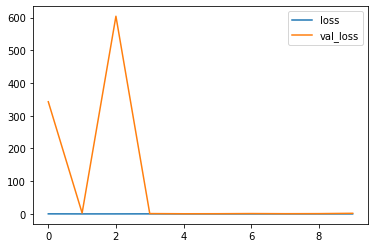

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

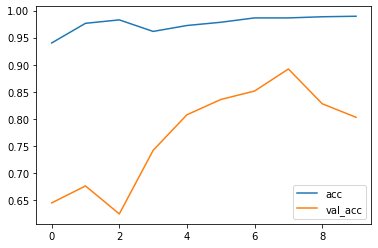

In [19]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [20]:
print(model.evaluate(test_ds, steps=validation_steps))

20/20 [==============================] - 4s 195ms/step - loss: 1.8892 - accuracy: 0.8047
[1.889170628786087, 0.8046875]


In [21]:
val_images = list(validation_dir.glob('*/*.jpeg'))
val_images = [str(path) for path in val_images]
random.shuffle(val_images)

val_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in val_images]

**FIRST PREDICTION**

In [22]:
val_img_path = val_images[0]
label = train_image_labels[0]

val_image = load_and_preprocess_image(val_img_path)
val_image = np.expand_dims(val_image, axis=0)

predictions = model.predict(val_image)

predicted PNEUMONIA
actual PNEUMONIA


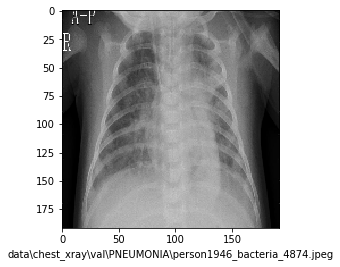

In [23]:
plt.imshow(load_and_preprocess_image(val_img_path))
plt.grid(False)
plt.xlabel(val_img_path)

index_to_label = dict(zip(label_to_index.values(),label_to_index.keys()))
print("predicted", index_to_label[np.argmax(predictions)])
print("actual", index_to_label[label])

**SECOND PREDICTION**

In [24]:
val_img_path = val_images[1]
label = train_image_labels[1]

val_image = load_and_preprocess_image(val_img_path)
val_image = np.expand_dims(val_image, axis=0)

predictions = model.predict(val_image)

predicted PNEUMONIA
actual PNEUMONIA


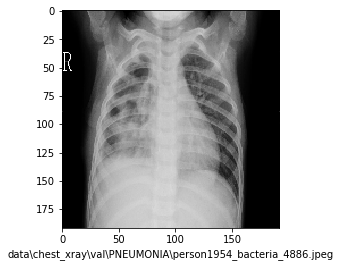

In [25]:
plt.imshow(load_and_preprocess_image(val_img_path))
plt.grid(False)
plt.xlabel(val_img_path)

index_to_label = dict(zip(label_to_index.values(),label_to_index.keys()))
print("predicted", index_to_label[np.argmax(predictions)])
print("actual", index_to_label[label])